In [0]:
import pandas as pd
import numpy as np
import re
import warnings

Let's create a folder on google drive to save files

In [0]:
import os

def create_directory(directory_name):

  if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print('The folder was successfully created')
  else:
    print('The folder exists')

In [0]:
# warnings.filterwarnings('ignore')
pd.options.display.max_columns = 2

def laoding_data(url):
  data = pd.read_csv(url, compression = 'gzip', delimiter=',')

  return data

url = 'http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2020-02-14/data/listings.csv.gz'

listings = laoding_data(url)
print('The listings data has {} features and {} entries'.format(listings.shape[1], listings.shape[0]))
listings.head(2)

The listings data has 106 features and 19700 entries


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,id,...,reviews_per_month
0,2818,...,2.09
1,20168,...,2.65


In [0]:
listings.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19700 entries, 0 to 19699
Data columns (total 106 columns):
id                                              19700 non-null int64
listing_url                                     19700 non-null object
scrape_id                                       19700 non-null int64
last_scraped                                    19700 non-null object
name                                            19667 non-null object
summary                                         19102 non-null object
space                                           14462 non-null object
description                                     19471 non-null object
experiences_offered                             19700 non-null object
neighborhood_overview                           13548 non-null object
notes                                           8265 non-null object
transit                                         13765 non-null object
access                                          11141

As it can be seen in the above cell result most of the columns have null values. There are even columns which don't have any entry at all. Let's determine the percentage of null values in each column and drop columns which have more than 50 percent null values

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

nrow = listings.shape[0]
ncolumn = listings.shape[1]

def null_stat(dataframe):

  # Let's first remove any special characters such as '?' or '-' in every columns 
  dataframe = dataframe.replace(['?','-','none'],np.nan)
  nulls = dataframe.isnull().sum()*100/len(dataframe)

  # let's exclude columns which do not have nulls
  nulls = nulls[nulls>0]
  nulls.sort_values(inplace = True)
  nulls = nulls.to_frame().reset_index()
  nulls.columns = ['Column Name', 'Nulls in percentage']


  #plot the missing value count
  fig = plt.figure(figsize=(10,6))
  ax = sns.barplot(x = 'Column Name', y = 'Nulls in percentage', data=nulls)
  ax.set_title('Bar plot of nulls in percentage of each column')
  plt.xticks(rotation = 90)
  plt.show()

  return nulls

# Remove columns more than 50 percent null values
def remove_nulls(dataframe):

  nulls = null_stat(dataframe)
  null_columns = nulls['Column Name'][nulls['Nulls in percentage']>50].tolist()
  dataframe.drop(null_columns, axis = 1, inplace = True)

  print('{} columns of containing more than 50 percent null values were removed'.
        format(ncolumn-dataframe.shape[1]))
  
  return dataframe

Moreover let's remove columns who have more than fifty percent null values. Besides as it can be easily observed we need to cast some features of type `object` into `float`

In [0]:
import re

# function filtering out url columns
def url_columns(list):
  pattern = re.compile(r'\w+[_]url')
  matches = pattern.search(list)

  if matches:
    matches = matches[0]

    return matches

# function removing url columns and scrape_id
def remove_url(dataframe):
  
  df = remove_nulls(dataframe)
  columns = df.columns.tolist()
  url_column = [url_columns(x) for x in columns if url_columns(x)]
  url_column.append('scrape_id')
  col = df.shape[1]

  df.drop(url_column, axis = 1, inplace = True)
  print('{} url columns were removed'.format(col - df.shape[1]))

  return df

Cetrain columns of type numeric have zero entries. For example price column has zero entry which . This makes the entire row irrelevant. Therefore the entrire row containing zero price must be dropped. Same can be said to 'bedrooms','bathrooms', and 'bed' also. 

In [0]:
 # Retain rows where all values of columns [price, bedroom, bathrooms, beds] are non-zero
 # That is equivalent to removing rows where either of these rows is zero
def remove_zeros(dataframe, column_list):
   
  # removing zero entries of columns in column_list
  new_df = remove_url(dataframe)
  rows = new_df.shape[0]
  dataframe = new_df[(new_df[column_list]!=0).all(axis=1)]
  print("{} rows were deleted having zero entries for either price, bedroom, bathrooms or beds".format(rows-dataframe.shape[0]))

  return dataframe

# Cleaning and casting object data type to float for these columns:
# ['host_response_rate','security_deposit','cleaning_fee','extra_people', 'price']
def cleaned_listing(dataframe,num_list, column_list):
  # call the last function
  df = remove_zeros(dataframe, column_list)
  for list in num_list:
    df[list] = df[list].replace(r'[^\d.]','', regex = True).astype(float)
  print('Price column has data type of {}'.format(df['price'].dtype))
  print('Cleaned listing dataframe has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
  
  # Take price column to the end
  columns = [list for list in df.columns if list!='price']
  df = df[columns + ['price']]
  
  return df

The folder exists


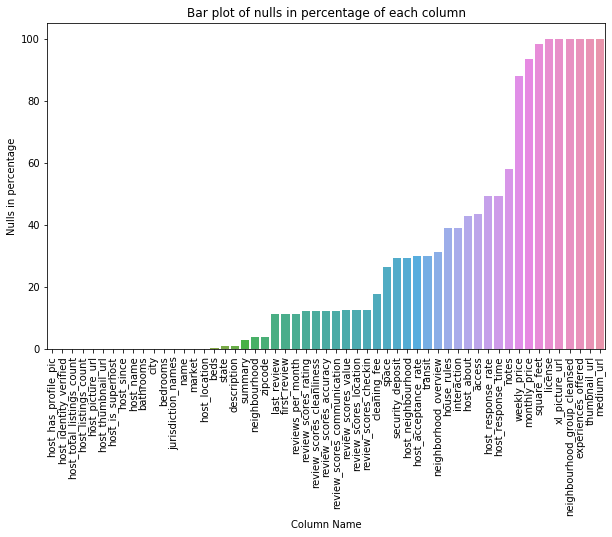

10 columns of containing more than 50 percent null values were removed
6 url columns were removed
1371 rows were deleted having zero entries for either price, bedroom, bathrooms or beds
Price column has data type of float64
Cleaned listing dataframe has 18329 rows and 90 columns


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
import pickle
num_list = ['host_response_rate','security_deposit','cleaning_fee','extra_people', 'price']
column_list = ['price','bedrooms','bathrooms','beds']
loaded = False

directory_name = "/content/drive/My Drive/airbnb"
create_directory(directory_name)
try:
    with open(os.path.join(directory_name, 'listings.pkl'), 'br') as k:
        df_listings = pickle.load(k)
        print('Listings data loaded.')
        loaded = True
except:
    pass

if not loaded:
    df_listings = cleaned_listing(listings,num_list,column_list)
    with open(os.path.join(directory_name, 'listings.pkl'), 'wb') as m:
        pickle.dump(df_listings, m)